### Import libraries

In [125]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.utilities import regressor_coefficients
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats import chisquare, zscore
from prophet import Prophet

### Ingest data and plot target variable

In [126]:
#Ingest data
df_macro = pd.read_csv('/Users/adrianlechter/Copy of Data Set (Make a Copy) - Macro Data (exportable).csv')
df_price = pd.read_csv('/Users/adrianlechter/Copy of Data Set (Make a Copy) - Price History.csv')

#Standardize date column names and convert them to datetime
df_macro.rename(columns={'observation_date':'Year-Month'}, inplace=True)
df_macro['Year-Month'] = pd.to_datetime(df_macro['Year-Month'])
df_price['Year-Month'] = pd.to_datetime(df_price['Year-Month'])

pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 999)
display('df_macro')
display(df_macro.head())
display('')
display('df_price')
display(df_price.head())
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 5)

'df_macro'

,Year-Month,FEDFUNDS,PAYNSA,PAYEMS,LNU01300000,CIVPART,UNRATENSA,UNRATE,PSAVERT,UMCSENT,MCOILWTICO,CPILFENS,CPILFESL,CPIAUCNS,CPIAUCSL,HOUST,HOUSTNSA
0,2019-01-01,2.40,147879,150100,63.0,63.0,4.0,4.0,9.0,91.0,51.0,260.0,261.0,252.0,252.0,1232.0,87.0
1,2019-02-01,2.40,148684,150124,63.0,63.0,4.0,4.0,10.0,94.0,55.0,261.0,261.0,253.0,253.0,1129.0,80.0
2,2019-03-01,2.41,149359,150348,63.0,63.0,4.0,4.0,9.0,98.0,58.0,262.0,261.0,254.0,254.0,1200.0,98.0
3,2019-04-01,2.42,150421,150636,63.0,63.0,3.0,4.0,9.0,97.0,64.0,262.0,262.0,256.0,255.0,1280.0,117.0
4,2019-05-01,2.39,151094,150713,63.0,63.0,3.0,4.0,9.0,100.0,61.0,263.0,262.0,256.0,255.0,1308.0,118.0


''

'df_price'

,Year-Month,Market 1,Market 2,Market 3,Market 4,Market 5,Market 6,Market 7,Market 8,Market 9,Market 10,Market 11,Market 12,Market 13,Market 14,Market 15,Market 16,Market 17,Market 18,Market 19,Market 20,20-Market Composite
0,2019-01-01,187.21,280.26,251.29,257.84,215.64,226.92,240.32,214.30,148.40,141.57,214.35,123.14,171.46,159.52,189.72,201.10,121.61,231.41,188.20,243.63,212.09
1,2019-02-01,187.50,280.23,253.76,259.37,217.63,227.59,240.54,215.70,148.92,141.52,213.45,123.22,170.79,159.34,190.09,200.76,121.45,231.47,188.54,244.96,212.37
2,2019-03-01,188.30,281.67,256.37,264.53,219.80,229.77,242.05,216.74,149.99,142.30,216.97,123.69,172.61,160.57,190.29,200.28,122.35,233.07,189.08,249.03,213.79
3,2019-04-01,189.72,284.21,257.57,268.77,221.53,232.12,242.47,218.25,151.54,143.97,220.86,125.72,174.18,162.18,191.40,200.28,123.24,235.66,190.32,251.69,215.50
4,2019-05-01,191.08,286.47,259.99,269.59,222.76,233.73,242.97,218.51,152.51,145.05,221.81,127.24,177.11,163.66,192.59,200.53,124.93,238.08,191.30,254.12,216.77


Text(0.5, 1.0, 'Market Prices \n 2019-2022 (red = Composite)')

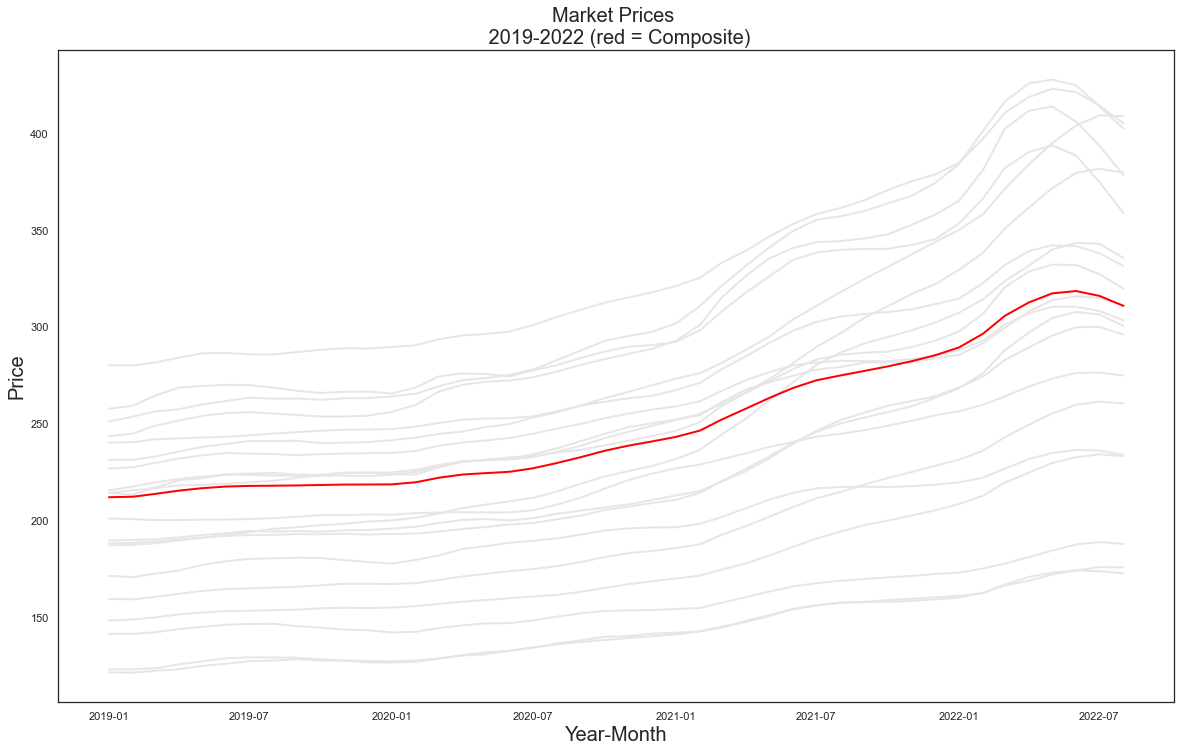

In [127]:
#Modify data to be graphed in lineplot
df_price_lineplot =\
    df_price.melt(id_vars=['Year-Month'], var_name='Market', value_name='Price')

#Graph all the market data

sns.set(rc={"figure.figsize":(20, 12)})
sns.set(style="white")
palette = ['#e6e6e6', '#e6e6e6', '#e6e6e6', '#e6e6e6', '#e6e6e6', '#e6e6e6', '#e6e6e6', '#e6e6e6',
           '#e6e6e6', '#e6e6e6', '#e6e6e6', '#e6e6e6', '#e6e6e6', '#e6e6e6', '#e6e6e6', '#e6e6e6',
           '#e6e6e6', '#e6e6e6', '#e6e6e6', '#e6e6e6', 'red']


ax = sns.lineplot(data=df_price_lineplot,x="Year-Month",y="Price",hue="Market",
            palette=palette, linewidth = 2)

for line in ax.lines:
    if line.get_label() == '20-Market Composite':
        line.set_linewidth(20)
        line.set_color('yellow')
        
ax.set_xlabel('Year-Month', fontsize = 15)
ax.set_ylabel('Price', fontsize = 15)

plt.legend([],[], frameon=False)

plt.xlabel('Year-Month', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Market Prices \n 2019-2022 (red = Composite)', fontsize = 20)

### Data Inspection: Check for Correlations amongst Predictors and Remove Highly Correlated Predictors

<AxesSubplot:>

Text(0.5, 1.0, 'Correlations Amongst all Predictors')

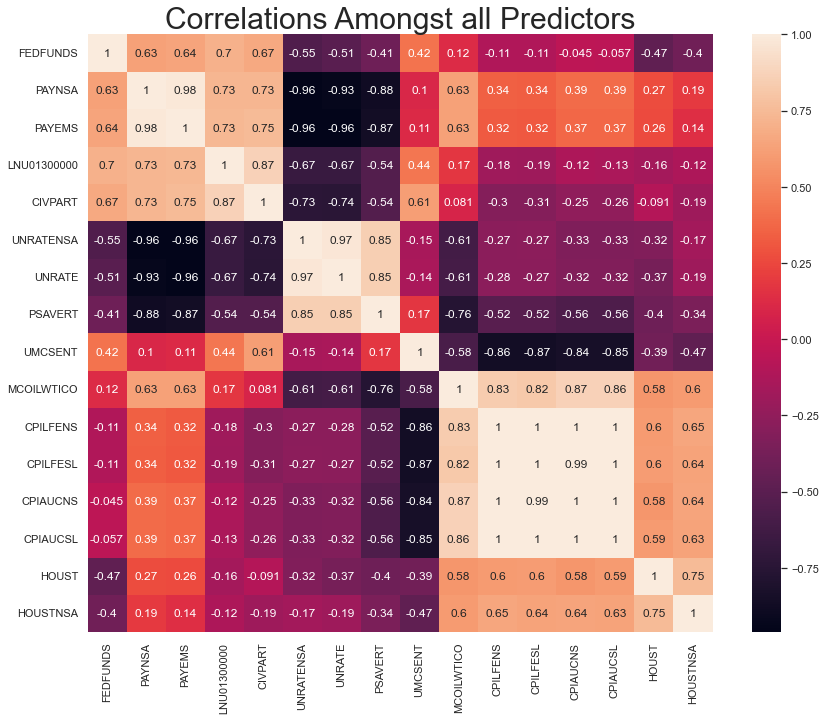

In [128]:
plt.figure(figsize=(14,11))
display(sns.heatmap(df_macro.corr(), annot = True ))
plt.title('Correlations Amongst all Predictors', fontdict= {'fontsize':30})

,Year-Month,PAYEMS,CIVPART,UNRATE,PSAVERT,CPILFESL,CPIAUCSL,HOUST
0,2019-01-01,150100,63.0,4.0,9.0,261.0,252.0,1232.0
1,2019-02-01,150124,63.0,4.0,10.0,261.0,253.0,1129.0
2,2019-03-01,150348,63.0,4.0,9.0,261.0,254.0,1200.0
3,2019-04-01,150636,63.0,4.0,9.0,262.0,255.0,1280.0
4,2019-05-01,150713,63.0,4.0,9.0,262.0,255.0,1308.0


<AxesSubplot:>

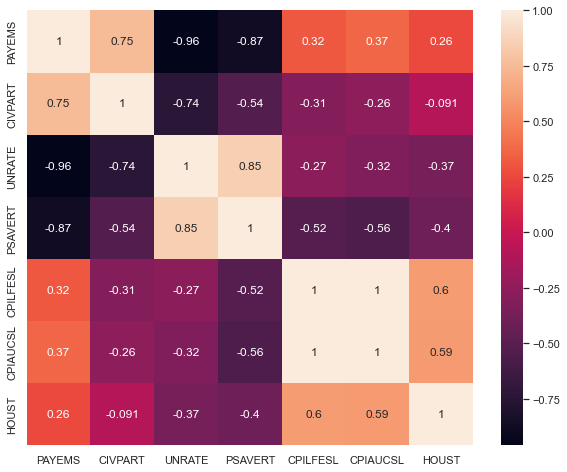

In [129]:
#Drop the non-seasonally adjusted values from dataframe
# (we remove fed funds rate and crude oil amongst others which would be useful to explore)
columns =\
    ['PAYNSA', 'LNU01300000', 'UNRATENSA', 'UMCSENT' , 
     'CPILFENS', 'CPIAUCNS', 'HOUSTNSA', 'FEDFUNDS', 'UMCSENT', 
     'MCOILWTICO'
    ]
df_macro_first_drop = df_macro.drop(columns=columns)
pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 999)
display(df_macro_first_drop.head())

plt.figure(figsize=(10,8))
display(sns.heatmap(df_macro_first_drop.corr(), annot = True ))
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 5)

<AxesSubplot:>

Text(0.5, 1.0, 'Correlations Amongst Model Predictors')

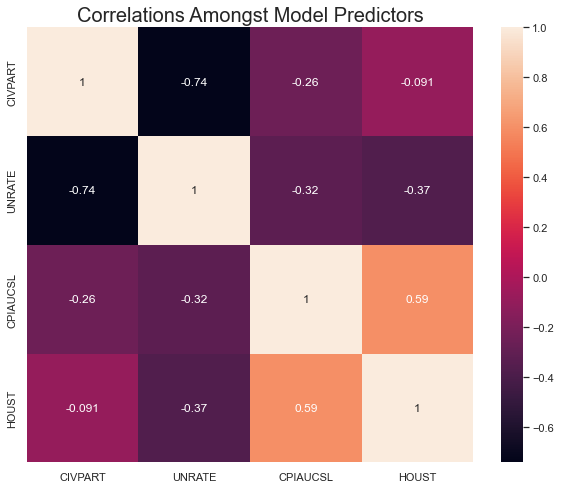

In [130]:
#We drop one of the consumer price index values, personal savings rate 
# and nonfarm payrolls because of high multicollinearity

plt.figure(figsize=(10,8))
df_macro_second_drop =\
    df_macro_first_drop.drop(columns=['PAYEMS', 'CPILFESL', 'PSAVERT'])
display(sns.heatmap(df_macro_second_drop.corr(), annot = True ))
plt.title('Correlations Amongst Model Predictors', fontdict= {'fontsize':20})


In [131]:
display('Here is the data with correlated predictors removed')
display(df_macro_second_drop.head())
display(df_macro_second_drop.tail())
display('')

display('Now we join this with 20-market composite data')
df_master =\
    pd.merge(df_macro_second_drop, df_price[['Year-Month','20-Market Composite']], on='Year-Month')
df_master.rename(columns={'20-Market Composite':'Target'}, inplace=True)
df_master.index = df_master['Year-Month']
display(df_master.head())
display(df_master.tail())

'Here is the data with correlated predictors removed'

,Year-Month,CIVPART,UNRATE,CPIAUCSL,HOUST
0,2019-01-01,63.0,4.0,252.0,1232.0
1,2019-02-01,63.0,4.0,253.0,1129.0
2,2019-03-01,63.0,4.0,254.0,1200.0
3,2019-04-01,63.0,4.0,255.0,1280.0
4,2019-05-01,63.0,4.0,255.0,1308.0


,Year-Month,CIVPART,UNRATE,CPIAUCSL,HOUST
41,2022-06-01,62.0,4.0,295.000,1575.0
42,2022-07-01,62.0,4.0,295.000,1377.0
43,2022-08-01,62.0,4.0,296.000,1566.0
44,2022-09-01,62.0,4.0,297.000,1439.0
45,2022-10-01,62.2,3.7,298.062,NaN


''

'Now we join this with 20-market composite data'

,Year-Month,CIVPART,UNRATE,CPIAUCSL,HOUST,Target
Year-Month,,,,,,
2019-01-01,2019-01-01,63.0,4.0,252.0,1232.0,212.09
2019-02-01,2019-02-01,63.0,4.0,253.0,1129.0,212.37
2019-03-01,2019-03-01,63.0,4.0,254.0,1200.0,213.79
2019-04-01,2019-04-01,63.0,4.0,255.0,1280.0,215.50
2019-05-01,2019-05-01,63.0,4.0,255.0,1308.0,216.77


,Year-Month,CIVPART,UNRATE,CPIAUCSL,HOUST,Target
Year-Month,,,,,,
2022-04-01,2022-04-01,62.0,4.0,289.0,1805.0,312.75
2022-05-01,2022-05-01,62.0,4.0,291.0,1562.0,317.42
2022-06-01,2022-06-01,62.0,4.0,295.0,1575.0,318.64
2022-07-01,2022-07-01,62.0,4.0,295.0,1377.0,316.14
2022-08-01,2022-08-01,62.0,4.0,296.0,1566.0,310.99


### Data Inspection: check for seasonality in target variable

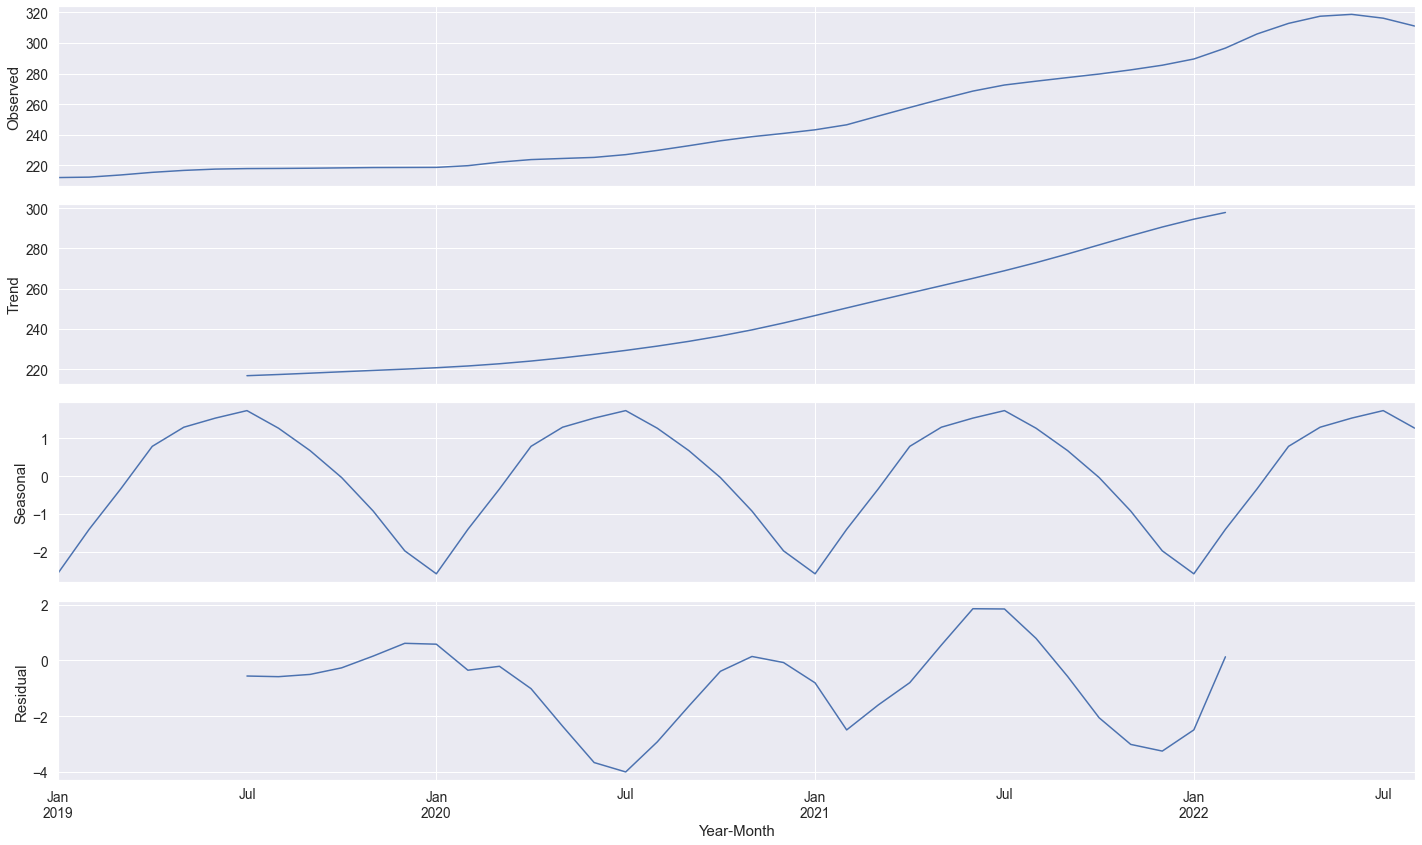

In [132]:
#Generate trend, seasonality and residual graph
sns.set(font_scale=1.25)
decomposition = sm.tsa.seasonal_decompose(df_master['Target'], model = 'additive')
fig = decomposition.plot()
plt.rcParams['figure.figsize'] = [12.0,10.0]


### Data pre-processing: Standardize predictors to improve model accuracy

In [133]:
#Reset font scaling for future graphs
sns.set(font_scale=1)

#Standardize predictors
df_master_model = df_master.copy()
df_master_model['CIVPART'] = zscore(df_master_model['CIVPART'])
df_master_model['UNRATE'] = zscore(df_master_model['UNRATE'])
df_master_model['CPIAUCSL'] = zscore(df_master_model['CPIAUCSL'])
df_master_model['HOUST'] = zscore(df_master_model['HOUST'])

### Split data into training + test sets

In [134]:
# Dividing data in test and train
df_train = df_master_model[:int(len(df_master_model)*.80)]
df_test = df_master_model[int(len(df_master_model)*.80):]
df=df_train

### Model 1: No Adjustments to Composite Prices

In [135]:
# Renaming column as per prophet library
df_train = df_train.rename(columns={'Target': 'y', 'Year-Month':'ds'})
df_test = df_test.rename(columns={'Target': 'y', 'Year-Month':'ds'})
df_train['y_orig'] = df_train['y']

In [136]:
model_new = Prophet(changepoint_range=0.8, seasonality_mode='additive', yearly_seasonality=False, weekly_seasonality=False, 
         daily_seasonality=False).add_seasonality(name='Yearly', period=365, fourier_order = 10)

model_new.add_regressor('CIVPART')
model_new.add_regressor('UNRATE')
model_new.add_regressor('CPIAUCSL')
model_new.add_regressor('HOUST')

In [137]:
# Fit model
model_new.fit(df_train)

18:16:18 - cmdstanpy - INFO - Chain [1] start processing
18:16:39 - cmdstanpy - INFO - Chain [1] done processing


In [138]:
# Perform cross validation
baseline_model_cv =\
    cross_validation(model=model_new, initial='700 days', 
                     horizon = '180 days', 
                     parallel="processes")
baseline_model_cv.head()

18:16:39 - cmdstanpy - INFO - Chain [1] start processing
18:16:39 - cmdstanpy - INFO - Chain [1] start processing
18:16:55 - cmdstanpy - INFO - Chain [1] done processing
18:16:58 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-03-01,236.331504,236.041235,236.650706,252.24,2021-02-04
1,2021-04-01,221.745615,220.781248,222.697247,257.84,2021-02-04
2,2021-05-01,235.732880,233.823116,237.533921,263.33,2021-02-04
3,2021-06-01,218.953582,215.873503,221.761226,268.55,2021-02-04
4,2021-07-01,249.308149,244.972839,253.351530,272.52,2021-02-04


In [139]:
#Generate model predictions
prediction = model_new.predict(df_test)
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,...,extra_regressors_additive_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-01,290.192952,284.123277,284.853261,289.806557,...,-2.906393,0.0,0.0,0.0,284.509673
1,2022-01-01,294.220553,285.189108,287.624140,292.879562,...,-3.420595,0.0,0.0,0.0,286.530099
...,...,...,...,...,...,...,...,...,...,...,...
7,2022-07-01,317.736544,303.992905,326.402930,306.242337,...,-6.176130,0.0,0.0,0.0,315.487112
8,2022-08-01,321.764145,304.470148,331.338086,307.965349,...,-6.056688,0.0,0.0,0.0,318.268944


In [140]:
#Study predictions with core model columns
forecast_data_orig = prediction # make sure we save the original forecast data
forecast_data_orig = forecast_data_orig[['ds', 'yhat', 'CIVPART','HOUST', 'CPIAUCSL', 'UNRATE']]
forecast_data_orig

,ds,yhat,CIVPART,HOUST,CPIAUCSL,UNRATE
0,2021-12-01,284.509673,0.002651,0.544778,-3.314032,-0.139789
1,2022-01-01,286.530099,0.002651,0.384747,-3.668203,-0.139789
...,...,...,...,...,...,...
7,2022-07-01,315.487112,0.002651,-0.068674,-5.970317,-0.139789
8,2022-08-01,318.268944,0.002651,0.227854,-6.147403,-0.139789


In [141]:
#Graph training data vs predictions
plot_plotly(model_new, prediction)

In [142]:
df_train.set_index('ds', inplace=True)
df_test.set_index('ds', inplace=True)
forecast_data_orig.set_index('ds', inplace=True)

Text(0.5, 1.0, 'Training and Testing Data vs Predicted Values')

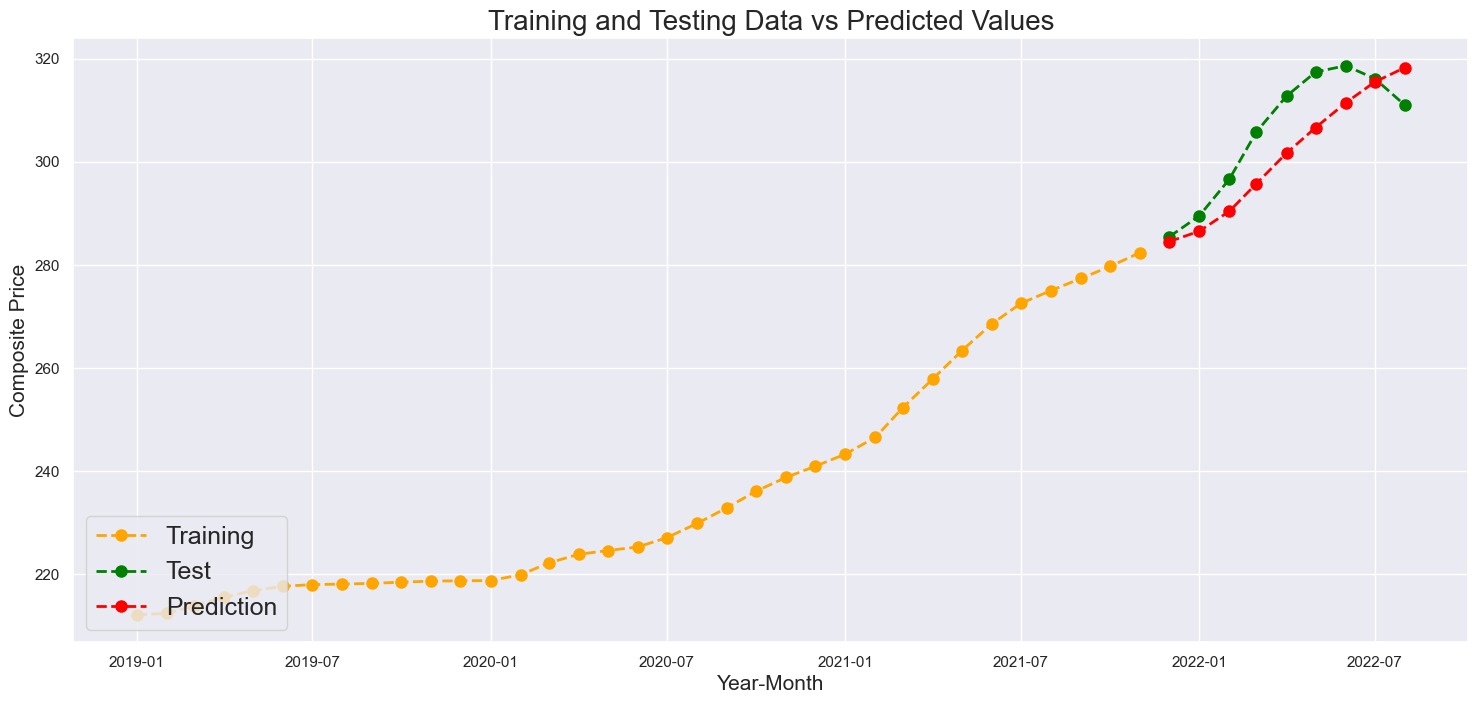

In [143]:
#Graph training and testing data vs predictions
plt.figure(figsize=(18,8), dpi=100)
plt.plot(df_train['y'], color='orange', label = 'Training', marker='o', linestyle='dashed',  linewidth=2, markersize=8)
plt.plot(df_test['y'], color='green', label = 'Test', marker='o', linestyle='dashed',  linewidth=2, markersize=8)
plt.plot(forecast_data_orig['yhat'], color='red', label = 'Prediction',marker='o', linestyle='dashed',  linewidth=2, markersize=8)

plt.legend(loc="lower left")
plt.legend(loc="lower left", prop={'size': 18})
plt.ylabel('Composite Price', fontsize = 15)
plt.xlabel('Year-Month', fontsize = 15)
plt.title('Training and Testing Data vs Predicted Values', fontsize = 20)

In [144]:
res = df_test['y']-forecast_data_orig['yhat']
err = res/df_test['y']
rmse = np.sqrt((df_test['y'] - forecast_data_orig['yhat'])**2).mean()
print('The Root Mean Square Error of Our Prediction is {}'.format(round(rmse, 2)), 'Root Absolute Percent Error:', np.sqrt(np.mean(abs(err))))

The Root Mean Square Error of Our Prediction is 6.35 Root Absolute Percent Error: 0.14327786384855065


In [145]:
# Plotting components against predicted data
plot_components_plotly(model_new, prediction)

### Feature Importance for Model 1

In [146]:
#Calculate feature importance
regressor_coef = regressor_coefficients(model_new)
reg = regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')

In [147]:
#Graph feature importance
reg["Color"] = np.where(reg["coef"]<0, 'red', 'green')
reg.rename(columns = {'coef':'Coefficient', 'regressor':'Regressor'}, inplace=True)

# PLOT
fig = px.bar(reg,x="Regressor",y="Coefficient", title = 'Feature Importance across Economic Predictors')

# COLOR
fig.update_traces(marker_color=reg["Color"])

fig.show()

### Model 2: Predicting Differences in Composite Prices (Stationarity Adjustment)

In [148]:
#Change input data to look at price differences vs raw composite price values
pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 999)
display(df_master_model.head())
display(df_master_model.info())
df_master_model['Target_diff'] = df['Target'].diff()
df_master_model2 = df_master_model.drop(columns = ['Target'])
df_master_model2.rename(columns = {'Target_diff':'Target'}, inplace=True)
df_master_model2 = df_master_model2.reset_index(level=0, drop=True).reset_index()

#Manually fill rows with NaN
#(the diff() method wasnt populating the last couple rows of price data correctly
values = [3.05,4.06,7.12,9.2,6.93,4.67,1.22,-2.5,-5.15]
row_number = 35

for value in values:
    df_master_model2.loc[row_number, 'Target'] = value
    row_number += 1
    
display(df_master_model2.tail())
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 5)

,Year-Month,CIVPART,UNRATE,CPIAUCSL,HOUST,Target
Year-Month,,,,,,
2019-01-01,2019-01-01,1.147079,-0.6,-1.146691,-1.171362,212.09
2019-02-01,2019-02-01,1.147079,-0.6,-1.069896,-1.685214,212.37
2019-03-01,2019-03-01,1.147079,-0.6,-0.993101,-1.331005,213.79
2019-04-01,2019-04-01,1.147079,-0.6,-0.916306,-0.931896,215.50
2019-05-01,2019-05-01,1.147079,-0.6,-0.916306,-0.792208,216.77


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2019-01-01 to 2022-08-01
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Year-Month  44 non-null     datetime64[ns]
 1   CIVPART     44 non-null     float64       
 2   UNRATE      44 non-null     float64       
 3   CPIAUCSL    44 non-null     float64       
 4   HOUST       44 non-null     float64       
 5   Target      44 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 2.4 KB


None

,index,Year-Month,CIVPART,UNRATE,CPIAUCSL,HOUST,Target
39,39,2022-04-01,-0.294963,-0.6,1.694729,1.687255,6.93
40,40,2022-05-01,-0.294963,-0.6,1.848320,0.474962,4.67
41,41,2022-06-01,-0.294963,-0.6,2.155500,0.539817,1.22
42,42,2022-07-01,-0.294963,-0.6,2.155500,-0.447977,-2.50
43,43,2022-08-01,-0.294963,-0.6,2.232295,0.494918,-5.15


In [149]:
# Dividing data in test and train
df_train = df_master_model2[:int(len(df_master_model2)*.80)]
df_test = df_master_model2[int(len(df_master_model2)*.80):]
df=df_train

In [150]:
# Renaming column as per prophet library
df_train = df_train.rename(columns={'Target': 'y', 'Year-Month':'ds'})
df_test = df_test.rename(columns={'Target': 'y', 'Year-Month':'ds'})
df_train['y_orig'] = df_train['y']
display(df_train.head(3))
display(df_train.tail(3))

,index,ds,CIVPART,UNRATE,CPIAUCSL,HOUST,y,y_orig
0,0,2019-01-01,1.147079,-0.6,-1.146691,-1.171362,NaN,NaN
1,1,2019-02-01,1.147079,-0.6,-1.069896,-1.685214,0.28,0.28
2,2,2019-03-01,1.147079,-0.6,-0.993101,-1.331005,1.42,1.42


,index,ds,CIVPART,UNRATE,CPIAUCSL,HOUST,y,y_orig
32,32,2021-09-01,-0.294963,-0.2,0.542802,0.459996,2.36,2.36
33,33,2021-10-01,-0.294963,-0.2,0.773187,0.479951,2.32,2.32
34,34,2021-11-01,-0.294963,-0.6,0.926778,1.193358,2.70,2.70


In [151]:
#Create model
model_new = Prophet(changepoint_range=0.8, seasonality_mode='additive', yearly_seasonality=False, weekly_seasonality=False, 
         daily_seasonality=False).add_seasonality(name='Yearly', period=365, fourier_order = 10)

model_new.add_regressor('CIVPART')
model_new.add_regressor('UNRATE')
model_new.add_regressor('CPIAUCSL')
model_new.add_regressor('HOUST')

In [152]:
# Fit model
model_new.fit(df_train)

18:17:00 - cmdstanpy - INFO - Chain [1] start processing
18:17:00 - cmdstanpy - INFO - Chain [1] done processing


In [153]:
#Perform cross validation
baseline_model_cv =\
    cross_validation(model=model_new, initial='700 days', 
                     horizon = '180 days', 
                     parallel="processes")
baseline_model_cv.head()

18:17:00 - cmdstanpy - INFO - Chain [1] start processing
18:17:00 - cmdstanpy - INFO - Chain [1] start processing
18:17:00 - cmdstanpy - INFO - Chain [1] done processing
18:17:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-03-01,4.523903,4.523789,4.524009,5.70,2021-02-04
1,2021-04-01,-0.191561,-0.191926,-0.191214,5.60,2021-02-04
2,2021-05-01,-0.619091,-0.619774,-0.618374,5.49,2021-02-04
3,2021-06-01,-4.164412,-4.165425,-4.163247,5.22,2021-02-04
4,2021-07-01,-1.025427,-1.026870,-1.023783,3.97,2021-02-04


In [154]:
#Generate predictions
prediction = model_new.predict(df_test)
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,...,extra_regressors_additive_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-01,5.040084,1.800077,3.079239,5.040084,...,-1.027116,0.0,0.0,0.0,2.439992
1,2022-01-01,5.220609,-0.144434,1.116537,5.220609,...,-1.974315,0.0,0.0,0.0,0.489249
...,...,...,...,...,...,...,...,...,...,...,...
7,2022-07-01,6.274638,-0.273920,1.025359,6.274638,...,-6.185291,0.0,0.0,0.0,0.364189
8,2022-08-01,6.455163,0.430083,1.688521,6.455163,...,-5.410237,0.0,0.0,0.0,1.035712


In [155]:
#Only report core model values with predictions
forecast_data_orig = prediction # make sure we save the original forecast data
forecast_data_orig = forecast_data_orig[['ds', 'yhat', 'CIVPART','HOUST', 'CPIAUCSL', 'UNRATE']]
forecast_data_orig

,ds,yhat,CIVPART,HOUST,CPIAUCSL,UNRATE
0,2021-12-01,2.439992,0.256833,1.777649,-3.840572,0.778975
1,2022-01-01,0.489249,0.256833,1.246971,-4.257093,0.778975
...,...,...,...,...,...,...
7,2022-07-01,0.364189,0.256833,-0.256617,-6.964482,0.778975
8,2022-08-01,1.035712,0.256833,0.726698,-7.172743,0.778975


In [156]:
#Graph training data vs predictions
plot_plotly(model_new, prediction)

In [157]:
df_train.set_index('ds', inplace=True)
df_test.set_index('ds', inplace=True)
forecast_data_orig.set_index('ds', inplace=True)

Text(0.5, 1.0, 'Training and Testing Data vs Predicted Values \n (Difference Transformation)')

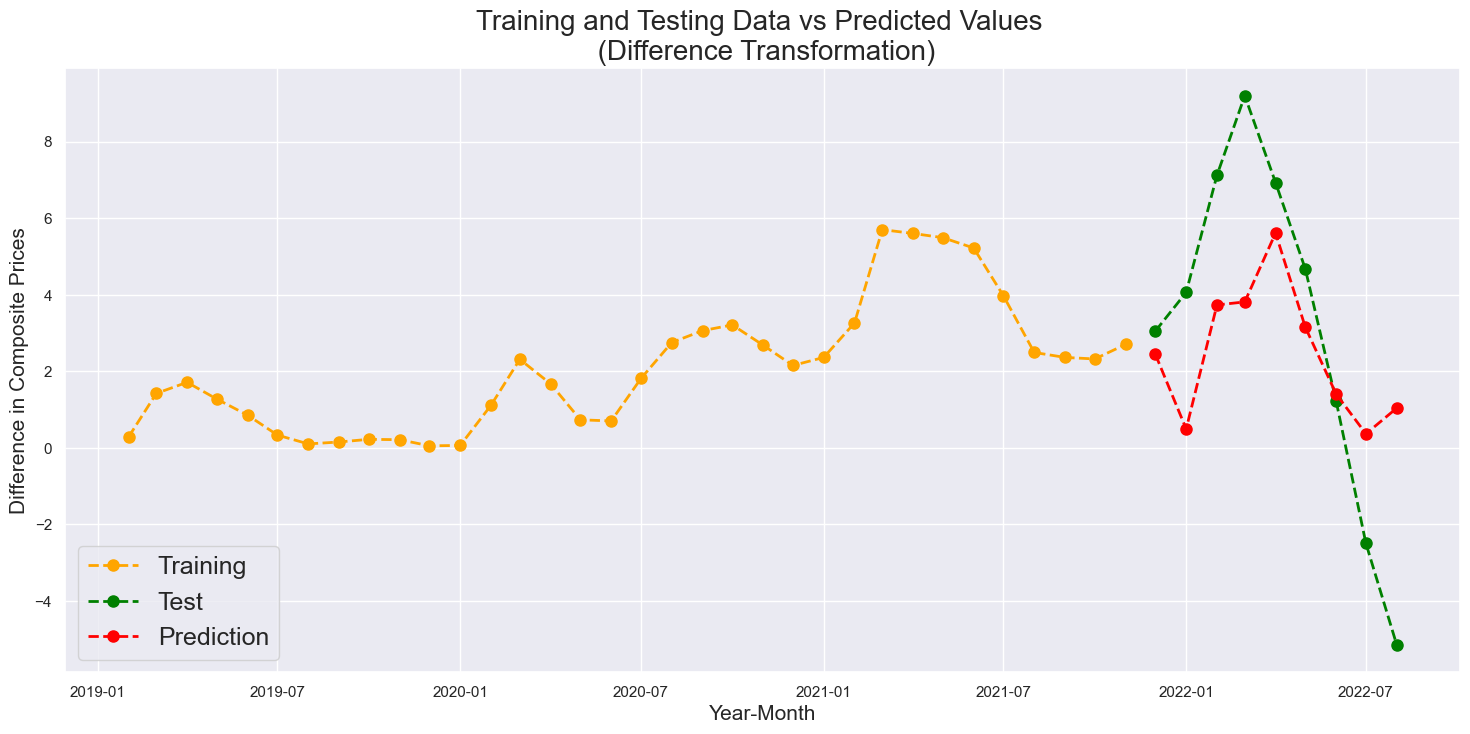

In [158]:
#Graph training and testing data vs predictions
plt.figure(figsize=(18,8), dpi=100)
plt.plot(df_train['y'], color='orange', label = 'Training', marker='o', linestyle='dashed',  linewidth=2, markersize=8)
plt.plot(df_test['y'], color='green', label = 'Test', marker='o', linestyle='dashed',  linewidth=2, markersize=8)
plt.plot(forecast_data_orig['yhat'], color='red', label = 'Prediction',marker='o', linestyle='dashed',  linewidth=2, markersize=8)

plt.legend(loc="lower left")
plt.legend(loc="lower left", prop={'size': 18})
plt.ylabel('Difference in Composite Prices', fontsize = 15)
plt.xlabel('Year-Month', fontsize = 15)
plt.title('Training and Testing Data vs Predicted Values \n (Difference Transformation)', fontsize = 20)
#plt.rcParams.update({'font.size': 20})

In [159]:
#Report error rate
res = df_test['y']-forecast_data_orig['yhat']
err = res/df_test['y']
rmse = np.sqrt((df_test['y'] - forecast_data_orig['yhat'])**2).mean()
print('The Root Mean Square Error of Our Prediction is {}'.format(round(rmse, 2)), 'Root Absolute Percent Error:', np.sqrt(np.mean(abs(err))))

The Root Mean Square Error of Our Prediction is 2.78 Root Absolute Percent Error: 0.7568075573097284


In [160]:
# Plotting components against predicted data
plot_components_plotly(model_new, prediction)

### Feature Importance for Model 2

In [161]:
#Generate feature importance
regressor_coef = regressor_coefficients(model_new)
reg = regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')

In [162]:
#Graph feature importance
reg["Color"] = np.where(reg["coef"]<0, 'red', 'green')
reg.rename(columns = {'coef':'Coefficient', 'regressor':'Regressor'}, inplace=True)

# PLOT
fig = px.bar(reg,x="Regressor",y="Coefficient", title = 'Feature Importance across Economic Predictors')

# COLOR
fig.update_traces(marker_color=reg["Color"])

fig.show()

### Model 3: Applying Log Transformation to Composite Price (Stationarity Adjustment)

In [163]:
#Change model data to look at log-transformed prices vs raw composite prices
pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 999)
display(df_master_model.head())
display(df_master_model.info())
# df_master_model['Target_diff'] = df['Target'].subtract(df['Target'].shift())
df_master_model['Target_log'] = np.log(df_master_model['Target'])
df_master_model3 = df_master_model.drop(columns = ['Target'])
df_master_model3.rename(columns = {'Target_log':'Target'}, inplace=True)
    
display(df_master_model3.head())
display(df_master_model3.tail())
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 5)

,Year-Month,CIVPART,UNRATE,CPIAUCSL,HOUST,Target,Target_diff
Year-Month,,,,,,,
2019-01-01,2019-01-01,1.147079,-0.6,-1.146691,-1.171362,212.09,NaN
2019-02-01,2019-02-01,1.147079,-0.6,-1.069896,-1.685214,212.37,0.28
2019-03-01,2019-03-01,1.147079,-0.6,-0.993101,-1.331005,213.79,1.42
2019-04-01,2019-04-01,1.147079,-0.6,-0.916306,-0.931896,215.50,1.71
2019-05-01,2019-05-01,1.147079,-0.6,-0.916306,-0.792208,216.77,1.27


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2019-01-01 to 2022-08-01
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Year-Month   44 non-null     datetime64[ns]
 1   CIVPART      44 non-null     float64       
 2   UNRATE       44 non-null     float64       
 3   CPIAUCSL     44 non-null     float64       
 4   HOUST        44 non-null     float64       
 5   Target       44 non-null     float64       
 6   Target_diff  34 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 2.8 KB


None

,Year-Month,CIVPART,UNRATE,CPIAUCSL,HOUST,Target_diff,Target
Year-Month,,,,,,,
2019-01-01,2019-01-01,1.147079,-0.6,-1.146691,-1.171362,NaN,5.357011
2019-02-01,2019-02-01,1.147079,-0.6,-1.069896,-1.685214,0.28,5.358330
2019-03-01,2019-03-01,1.147079,-0.6,-0.993101,-1.331005,1.42,5.364994
2019-04-01,2019-04-01,1.147079,-0.6,-0.916306,-0.931896,1.71,5.372961
2019-05-01,2019-05-01,1.147079,-0.6,-0.916306,-0.792208,1.27,5.378837


,Year-Month,CIVPART,UNRATE,CPIAUCSL,HOUST,Target_diff,Target
Year-Month,,,,,,,
2022-04-01,2022-04-01,-0.294963,-0.6,1.694729,1.687255,NaN,5.745404
2022-05-01,2022-05-01,-0.294963,-0.6,1.848320,0.474962,NaN,5.760226
2022-06-01,2022-06-01,-0.294963,-0.6,2.155500,0.539817,NaN,5.764062
2022-07-01,2022-07-01,-0.294963,-0.6,2.155500,-0.447977,NaN,5.756185
2022-08-01,2022-08-01,-0.294963,-0.6,2.232295,0.494918,NaN,5.739761


In [164]:
# Dividing data in test and train
df_train = df_master_model3[:int(len(df_master_model3)*.80)]
df_test = df_master_model3[int(len(df_master_model3)*.80):]
df=df_train

In [165]:
# Renaming column as per prophet library
df_train = df_train.rename(columns={'Target': 'y', 'Year-Month':'ds'})
df_test = df_test.rename(columns={'Target': 'y', 'Year-Month':'ds'})
df_train['y_orig'] = df_train['y']
display(df_train.head(3))
display(df_train.tail(3))

,ds,CIVPART,UNRATE,CPIAUCSL,HOUST,Target_diff,y,y_orig
Year-Month,,,,,,,,
2019-01-01,2019-01-01,1.147079,-0.6,-1.146691,-1.171362,NaN,5.357011,5.357011
2019-02-01,2019-02-01,1.147079,-0.6,-1.069896,-1.685214,0.28,5.358330,5.358330
2019-03-01,2019-03-01,1.147079,-0.6,-0.993101,-1.331005,1.42,5.364994,5.364994


,ds,CIVPART,UNRATE,CPIAUCSL,HOUST,Target_diff,y,y_orig
Year-Month,,,,,,,,
2021-09-01,2021-09-01,-0.294963,-0.2,0.542802,0.459996,2.36,5.625352,5.625352
2021-10-01,2021-10-01,-0.294963,-0.2,0.773187,0.479951,2.32,5.633682,5.633682
2021-11-01,2021-11-01,-0.294963,-0.6,0.926778,1.193358,2.70,5.643289,5.643289


In [166]:
#Create model
model_new = Prophet(changepoint_range=0.8, seasonality_mode='additive', yearly_seasonality=False, weekly_seasonality=False, 
         daily_seasonality=False).add_seasonality(name='Yearly', period=365, fourier_order = 10)

model_new.add_regressor('CIVPART')
model_new.add_regressor('UNRATE')
model_new.add_regressor('CPIAUCSL')
model_new.add_regressor('HOUST')

In [167]:
# Fit model
model_new.fit(df_train)

18:17:18 - cmdstanpy - INFO - Chain [1] start processing
18:17:38 - cmdstanpy - INFO - Chain [1] done processing


In [168]:
# Cross validation
baseline_model_cv =\
    cross_validation(model=model_new, initial='700 days', 
                     horizon = '180 days', 
                     parallel="processes")
baseline_model_cv.head()

18:17:38 - cmdstanpy - INFO - Chain [1] start processing
18:17:38 - cmdstanpy - INFO - Chain [1] start processing
18:17:55 - cmdstanpy - INFO - Chain [1] done processing
18:17:57 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-03-01,5.605316,5.598934,5.612080,5.530381,2021-02-04
1,2021-04-01,5.668584,5.648531,5.688947,5.552339,2021-02-04
2,2021-05-01,5.655340,5.613845,5.697738,5.573408,2021-02-04
3,2021-06-01,5.767176,5.701527,5.835494,5.593037,2021-02-04
4,2021-07-01,5.647232,5.553982,5.741350,5.607712,2021-02-04


In [169]:
#Generate predictions
prediction = model_new.predict(df_test)
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,...,extra_regressors_additive_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-01,5.631221,5.661146,5.675718,5.624706,...,0.048565,0.0,0.0,0.0,5.667662
1,2022-01-01,5.643881,5.681232,5.729684,5.621399,...,0.057584,0.0,0.0,0.0,5.703714
...,...,...,...,...,...,...,...,...,...,...,...
7,2022-07-01,5.717800,5.617622,6.067356,5.500509,...,0.106910,0.0,0.0,0.0,5.834913
8,2022-08-01,5.730460,5.577729,6.109454,5.468805,...,0.105452,0.0,0.0,0.0,5.839384


In [170]:
#Only look at key model values with predictions
forecast_data_orig = prediction # make sure we save the original forecast data
forecast_data_orig = forecast_data_orig[['ds', 'yhat', 'CIVPART','HOUST', 'CPIAUCSL', 'UNRATE']]
forecast_data_orig

,ds,yhat,CIVPART,HOUST,CPIAUCSL,UNRATE
0,2021-12-01,5.667662,-0.001029,-0.008633,0.060663,-0.002436
1,2022-01-01,5.703714,-0.001029,-0.006097,0.067146,-0.002436
...,...,...,...,...,...,...
7,2022-07-01,5.834913,-0.001029,0.001088,0.109286,-0.002436
8,2022-08-01,5.839384,-0.001029,-0.003611,0.112527,-0.002436


In [171]:
#Plot training data vs predictions
plot_plotly(model_new, prediction)

In [172]:
df_train.set_index('ds', inplace=True)
df_test.set_index('ds', inplace=True)
forecast_data_orig.set_index('ds', inplace=True)

Text(0, 0.5, 'Log of Composite Price')

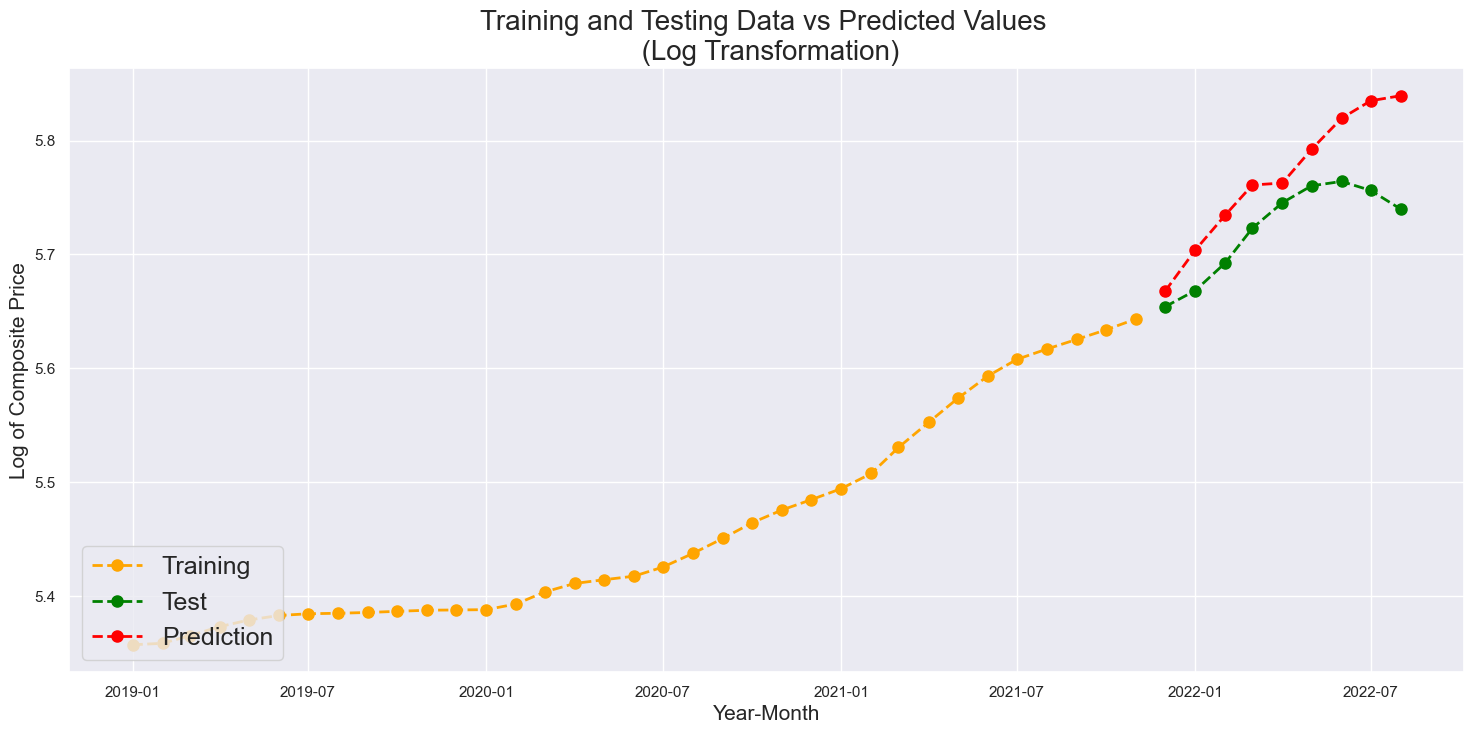

In [173]:
#Graph training and testing data vs predictions
plt.figure(figsize=(18,8), dpi=100)
plt.plot(df_train['y'], color='orange', label = 'Training', marker='o', linestyle='dashed',  linewidth=2, markersize=8)
plt.plot(df_test['y'], color='green', label = 'Test', marker='o', linestyle='dashed',  linewidth=2, markersize=8)
plt.plot(forecast_data_orig['yhat'], color='red', label = 'Prediction',marker='o', linestyle='dashed',  linewidth=2, markersize=8)

plt.legend(loc="lower left")
plt.legend(loc="lower left", prop={'size': 18})
plt.title('Training and Testing Data vs Predicted Values \n (Log Transformation)', fontsize = 20)
plt.xlabel('Year-Month', fontsize = 15)
plt.ylabel('Log of Composite Price', fontsize = 15)
#plt.rcParams.update({'font.size': 20})

In [174]:
#Calculate error rate
res = df_test['y']-forecast_data_orig['yhat']
err = res/df_test['y']
rmse = np.sqrt((df_test['y'] - forecast_data_orig['yhat'])**2).mean()
print('The Root Mean Square Error of Our Prediction is {}'.format(round(rmse, 2)), 'Root Absolute Percent Error:', np.sqrt(np.mean(abs(err))))

The Root Mean Square Error of Our Prediction is 0.05 Root Absolute Percent Error: 0.08939451367582797


In [175]:
# Plotting components against predicted data
plot_components_plotly(model_new, prediction)

### Feature Importance for Model  3

In [176]:
#Calculate feature importance
regressor_coef = regressor_coefficients(model_new)
reg = regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')

In [177]:
#Graph feature importance
reg["Color"] = np.where(reg["coef"]<0, 'red', 'green')
reg.rename(columns = {'coef':'Coefficient', 'regressor':'Regressor'}, inplace=True)

# PLOT
fig = px.bar(reg,x="Regressor",y="Coefficient", title = 'Feature Importance across Economic Predictors')

# COLOR
fig.update_traces(marker_color=reg["Color"])

fig.show()

In [178]:
import os
os.getcwd()

'/Users/adrianlechter'